In [ ]:
# Author: Yuki Rivera
# This notebook contains the implementation of RNN model building, training and some evaluation

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Embedding, TimeDistributed
import pandas as pd
from tensorflow.keras.models import load_model
import pickle
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LambdaCallback
import matplotlib.pyplot as plt
from tensorflow.keras.losses import sparse_categorical_crossentropy
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dropout

### Load the training dataset

In [ ]:
training_df = pd.read_csv('prompt_synopsis_train.csv')

In [ ]:
training_df.shape

(63278, 2)

### Randomly select 40000 rows from the pairs

In [ ]:
training_df = training_df.sample(n=40000, random_state=42)

### Data Preprocessing

In [ ]:
word_limit = 3000
pad_length = 60
vocab_size = 3000

In [ ]:
# instantiates a tokenizer
tokenizer = Tokenizer(num_words=word_limit)
# the tokenizer builds a single shared vocabulary across both the input and the output
tokenizer.fit_on_texts(training_df['prompt'].tolist() + training_df['synopsis'].tolist())

# converts each prompt or synopsis into a list of integers
input_seqs = tokenizer.texts_to_sequences(training_df['prompt'])
output_seqs = tokenizer.texts_to_sequences(training_df['synopsis'])

# pads the sequences 
padded_input = pad_sequences(input_seqs, maxlen=pad_length, truncating='post', padding='post')
padded_output = pad_sequences(output_seqs, maxlen=pad_length, truncating='post',padding='post')


### Defines RNN Model

In [ ]:
# creates a sequential to group a linear stack of layers into a model
model = Sequential()

# adds the embedding layer
model.add(Embedding(input_dim=vocab_size, output_dim=64))

# adds a dropout layer
# model.add(Dropout(0.2)) 

# adds the RNN layer
model.add(SimpleRNN(64, return_sequences=True))

# adds another RNN Layer
# model.add(SimpleRNN(64, return_sequences=True))  # Second RNN layer

# adds a dropout layer
# model.add(Dropout(0.2))

# adds the dense layer 
# wraps with TimeDistributed() so that the Dense layer is applied to each time step
model.add(TimeDistributed(Dense(vocab_size, activation='softmax')))

### Configures the model to train

In [ ]:
# compiles the model with loss, optimizer, and accuracy metric
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

### Display the model's performance during training

In [ ]:
# samples an index from predictions with temperature to control randomness
def sample_with_temperature(preds, temperature=0.7):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds + 1e-8) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

### Helper functions to see generated text during training

In [ ]:
# generates a synopsis by predicting one word at a time from a prompt
def generate_synopsis(prompt, tokenizer, model, max_words=50, pad_length=100, temperature=0.7):
    # tokenizes the prompt once
    generated_tokens = tokenizer.texts_to_sequences([prompt])[0]

    for _ in range(max_words):
        # pads sequence for model input
        input_seq = pad_sequences([generated_tokens], maxlen=pad_length, padding='pre')

        # predicts next token probabilities
        preds = model.predict(input_seq, verbose=0)[0][-1]

        # samples next token with temperature
        next_token = sample_with_temperature(preds, temperature)

        # stopts if no valid next token or end token is generated (optional)
        if next_token == 0 or next_token == tokenizer.word_index.get('<end>'):
            break

        # appends the predicted token to sequence
        generated_tokens.append(next_token)

    # decodes token IDs back to words
    generated_words = [tokenizer.index_word.get(token, '') for token in generated_tokens]

    # joins words to form the generated synopsis text
    generated_text = ' '.join(generated_words)

    return generated_text

### Callbacks for displaying the model's output change during training

In [ ]:
# helper Function to display the model's output during training
def make_epoch_callback(prompt, tokenizer, model):
    def on_epoch_end(epoch, logs):
        generated = generate_synopsis(prompt, tokenizer, model)
        print(f"\n--- Epoch {epoch + 1} ---")
        print("Prompt:", prompt)
        print("Generated:", generated)
    return LambdaCallback(on_epoch_end=on_epoch_end)

# Creates the callback with a sample prompt to see the progress
sample_prompt = "Create an anime with 'romance' and 'fantasy' for 'shoujo'."
print_callback = make_epoch_callback(sample_prompt, tokenizer, model)

### Callbacks for saving the best model & early stopping

In [ ]:
# Saves the best model
checkpoint_callback = ModelCheckpoint(
    "best_model.keras",   
    save_best_only=True,  
    monitor='val_loss',   
    mode='min'            
)

# Stops early if val_loss stops improving
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=4,
    min_delta=0.01,
    restore_best_weights=True
)

### Creates Training and Validation sets

In [ ]:
# Example: 80% train, 20% val
split_index = int(len(padded_input) * 0.8)

X_train_padded = padded_input[:split_index]
y_train_padded = padded_output[:split_index]
X_val_padded = padded_input[split_index:]
y_val_padded = padded_output[split_index:]


### Trains the model with validation data and callbacks included

In [ ]:
batch = 128 # 128:faster, 64: slower
repeat = 15

### Trains the model

In [ ]:
# trains the model with teacher-forcing
history = model.fit(
    X_train_padded, 
    y_train_padded, 
    validation_data=(X_val_padded, y_val_padded), 
    batch_size = batch,
    epochs = repeat,
    callbacks=[checkpoint_callback, early_stopping, print_callback] 
    )

Epoch 1/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - accuracy: 0.2070 - loss: 6.1061
--- Epoch 1 ---
Prompt: Create an anime with 'romance' and 'fantasy' for 'shoujo'.
Generated: create an anime with 'romance' and 'fantasy' for 'shoujo' who of on changes
250/250 ━━━━━━━━━━━━━━━━━━━━ 184s 724ms/step - accuracy: 0.2071 - loss: 6.1038 - val_accuracy: 0.2354 - val_loss: 5.1968
Epoch 2/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.2263 - loss: 5.2386
--- Epoch 2 ---
Prompt: Create an anime with 'romance' and 'fantasy' for 'shoujo'.
Generated: create an anime with 'romance' and 'fantasy' for 'shoujo' the two a on siblings of
250/250 ━━━━━━━━━━━━━━━━━━━━ 176s 705ms/step - accuracy: 0.2263 - loss: 5.2385 - val_accuracy: 0.2444 - val_loss: 5.1597
Epoch 3/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.2397 - loss: 5.1820
--- Epoch 3 ---
Prompt: Create an anime with 'romance' and 'fantasy' for 'shoujo'.
Generated: create an anime with 'romance' and 'fantasy' for 'sho

### Save the tokenizer

In [ ]:
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

### Save the training history

In [ ]:
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

### Plot the Loss Curve

In [ ]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


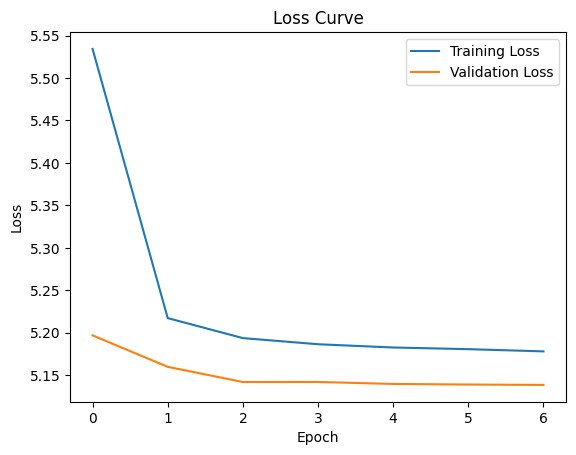

In [ ]:
# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Perplexity Calculation

In [ ]:
def calculate_perplexity_in_chunks(model, X_val_padded, y_val_padded, batch_size = 128, return_all = False):
    all_perplexities = []

    for i in range(0, len(X_val_padded), batch_size):
        x_batch = X_val_padded[i:i+batch_size]
        y_batch = y_val_padded[i:i+batch_size]

        # predicts probabilities on validation set
        y_pred = model.predict(x_batch, verbose = 0)


        # calculates cross-entropy loss per token
        loss_per_token = sparse_categorical_crossentropy(y_batch, y_pred)

        # creates mask to ignore 0 used for padding
        mask = tf.cast(tf.not_equal(y_batch, 0), tf.float32)

        # applies mask and calculates average loss per single input-output pair
        # by dividing total token loss by the number of real tokens
        masked_loss = loss_per_token * mask
        loss_per_sample = tf.reduce_sum(masked_loss, axis=1) / tf.reduce_sum(mask, axis=1)

        # computes perplexity per sample and average across all input-output pairs
        perplexity_batch = tf.exp(loss_per_sample)
        all_perplexities.extend(perplexity_batch.numpy())

    avg_perplexity = np.mean(all_perplexities)

    if return_all:
        return avg_perplexity, all_perplexities
    else:
        return avg_perplexity


### Computes validation perplexity

In [ ]:
ppl = calculate_perplexity_in_chunks(model, X_val_padded, y_val_padded, batch_size=64)
print(f"Validation Perplexity: {ppl:.2f}")

Validation Perplexity: 542.88
